# Generate full emissions portfolio from projected Kyoto gas baskets
Updated to include announcements as of COP26, 5/11/21. Including an analysis of full impact of Net Zero commitments on emissions.
# Part 2: harmonise data

In [1]:
import sys
stdout = sys.stdout

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pyam
import re
import seaborn as sns
from scipy.interpolate import interp1d, PchipInterpolator

<IPython.core.display.Javascript object>

In [3]:
from silicone.time_projectors import ExtendLatestTimeQuantile
import silicone.multiple_infillers as mi
import silicone.database_crunchers as dc
from silicone.utils import convert_units_to_MtCO2_equiv, _construct_consistent_values

In [4]:
version_no = "24.0"

# Import the data

In [5]:
co2 = "Emissions|CO2"
co2ind = "Emissions|CO2|Energy and Industrial Processes"
co2afolu = "Emissions|CO2|AFOLU"
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
kyexaf = variable + "|Excluding CO2 AFOLU"
unit = "Mt CO2-equiv/yr"
co2unit = "Mt CO2/yr"
years = [2015, 2019] + list(range(2010, 2101, 10))
start_harm_year = 2019

In [6]:
out_folder = f"../output/processed_files/{version_no}/"
sr15 = pyam.IamDataFrame(out_folder + "sr15_cleaned.csv")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ..\output\processed_files\24.0\sr15_cleaned.csv


In [7]:
# Import data on expected projection of emissions
readin_data = pd.read_excel(
    "../input/Data2030_forextensions_EGR2024_master.xlsx", sheet_name="Extracted data EGR2024")
readin_data.columns = ["scenario", "model"] + list(readin_data.columns[2:5]) + ["unit"]

In [8]:
readin_data

,scenario,model,2015,2019,2030,unit
0,Min,Current policies,55498.5247,56880.931713,51754.515639,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
1,Median,Current policies,55498.5247,56880.931713,57228.638549,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
2,Max,Current policies,55498.5247,56880.931713,58842.354925,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
3,Min,NDC case - unconditional,55498.5247,56880.931713,53555.498650,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
4,Median,NDC case - unconditional,55498.5247,56880.931713,54860.172356,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
5,Max,NDC case - unconditional,55498.5247,56880.931713,57394.095697,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
6,Min,NDC case - conditional,55498.5247,56880.931713,50497.091583,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
7,Median,NDC case - conditional,55498.5247,56880.931713,52171.201141,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...
8,Max,NDC case - conditional,55498.5247,56880.931713,55143.378851,MtCO2-eq/yr (aggregated with AR6 GWP-100 metri...


In [9]:
variable = "Emissions|Kyoto Gases (AR6-GWP100)"
unit = "Mt CO2-equiv/yr"
raw_data = readin_data
raw_data["region"] = "World"
raw_data["unit"] = unit
raw_data["variable"] = variable
raw_data = pyam.IamDataFrame(raw_data)
raw_data = raw_data.interpolate(2020)
raw_data.data.head()

,model,scenario,region,variable,unit,year,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2015,55498.524700
1,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2019,56880.931713
2,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2020,57059.242914
3,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,58842.354925
4,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2015,55498.524700


In [10]:
# Import historical database
histall = pd.read_excel("../input/essd_ghg_data.xlsx", sheet_name="data")
histall["variable"] = ["Emissions|" + x for x in histall["gas"]]
histall

,ISO,country,region_ar6_6,region_ar6_10,region_ar6_22,region_ar6_dev,year,sector_title,subsector_title,gas,gwp100_ar5,value,variable
0,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CO2,1,5.452099e+02,Emissions|CO2
1,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,CH4,28,1.609412e-01,Emissions|CH4
2,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Buildings,Residential,N2O,265,4.802031e-03,Emissions|N2O
3,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CO2,1,3.091397e+04,Emissions|CO2
4,ABW,Aruba,Latin America and Caribbean,Latin America and Caribbean,Caribbean,developing,1970,Energy systems,Electricity & heat,CH4,28,4.155721e-01,Emissions|CH4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568336,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Metals,CO2,1,7.720092e+05,Emissions|CO2
568337,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Industry,Other (industry),CO2,1,9.523549e+05,Emissions|CO2
568338,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Other (transport),CO2,1,3.099450e+05,Emissions|CO2
568339,ZWE,Zimbabwe,Africa,Africa,Eastern Africa,developing,2020,Transport,Rail,CO2,1,1.491236e+05,Emissions|CO2


In [11]:
region_dict = {
    'Latin America and Caribbean': "R5LAM",
    'Southern Asia': "R5ASIA", 
    'Africa': "R5MAF",
    'Intl. Aviation':"R5OECD90+EU",
    'Europe': "R5OECD90+EU", 
    'Middle East': "R5MAF", 
    'Eurasia': "R5REF",
    'South-East Asia and developing Pacific': "R5ASIA", 
    'Asia-Pacific Developed': "R5OECD90+EU",
    'North America': "R5OECD90+EU", 
    'Eastern Asia': "R5ASIA", 
    'Intl. Shipping': "R5OECD90+EU"
}
histall["region"] = [region_dict[x] for x in histall["region_ar6_10"]]

In [12]:
histall = histall.loc[~((histall.gas=="CO2") & (histall["subsector_title"]=='Managed soils and pasture (CO2, N2O)'))]
histallgroup = histall.drop(columns=["gwp100_ar5"]).groupby(["year", "variable", "region"]).sum()
histallworld = histallgroup.groupby(["year", "variable"]).sum()
histallworld["region"] = "World"
histallworld

value region
year variable                             
1970 Emissions|C2F6    1.155521e+03  World
     Emissions|C3F8    0.000000e+00  World
     Emissions|C4F10   0.000000e+00  World
     Emissions|C5F12   0.000000e+00  World
     Emissions|C6F14   0.000000e+00  World
...                             ...    ...
2019 Emissions|N2O     9.739023e+06  World
     Emissions|NF3     1.421996e+02  World
     Emissions|SF6     8.833537e+03  World
     Emissions|c-C4F8  7.714975e+01  World
2020 Emissions|CO2     3.582252e+10  World

[1401 rows x 2 columns]

In [13]:
histall = pd.concat([histallgroup.reset_index(), histallworld.reset_index()])
histall["scenario"] = "History"
histall["model"] = "EDGAR"
histall["variable"] = histall["variable"].str.replace("-", "")
histall["unit"] = ["t " + x.replace("Emissions|", "") + "/yr" for x in histall.variable]
histall["variable"] = histall["variable"].str.replace("HFC", "HFC|HFC")

In [14]:
# relabel the variable to clarify that CO2 does not include AFOLU. Also clarify some f-gas names
histall = pyam.IamDataFrame(histall)
histall = histall.rename({"variable":{
    "Emissions|CO2": co2ind, "Emissions|CF4": "Emissions|PFC|CF4", 
    "Emissions|C2F6": "Emissions|PFC|C2F6", "Emissions|HFC4310mee": "Emissions|HFC43-10"}
})
histall.variable

['Emissions|PFC|C2F6',
 'Emissions|C3F8',
 'Emissions|C4F10',
 'Emissions|PFC|CF4',
 'Emissions|CH4',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|HFC|HFC125',
 'Emissions|HFC|HFC134a',
 'Emissions|HFC|HFC143a',
 'Emissions|HFC|HFC152a',
 'Emissions|HFC|HFC227ea',
 'Emissions|HFC|HFC23',
 'Emissions|HFC|HFC236fa',
 'Emissions|HFC|HFC245fa',
 'Emissions|HFC|HFC32',
 'Emissions|HFC|HFC365mfc',
 'Emissions|N2O',
 'Emissions|NF3',
 'Emissions|SF6',
 'Emissions|cC4F8',
 'Emissions|HFC|HFC134',
 'Emissions|HFC|HFC4310mee',
 'Emissions|C5F12',
 'Emissions|C6F14',
 'Emissions|HFC|HFC143',
 'Emissions|HFC|HFC41']

In [15]:
histall.unit

['t C2F6/yr',
 't C3F8/yr',
 't C4F10/yr',
 't C5F12/yr',
 't C6F14/yr',
 't CF4/yr',
 't CH4/yr',
 't CO2/yr',
 't HCFC141b/yr',
 't HCFC142b/yr',
 't HFC125/yr',
 't HFC134/yr',
 't HFC134a/yr',
 't HFC143/yr',
 't HFC143a/yr',
 't HFC152a/yr',
 't HFC227ea/yr',
 't HFC23/yr',
 't HFC236fa/yr',
 't HFC245fa/yr',
 't HFC32/yr',
 't HFC365mfc/yr',
 't HFC41/yr',
 't HFC4310mee/yr',
 't N2O/yr',
 't NF3/yr',
 't SF6/yr',
 't cC4F8/yr']

In [16]:
for var in histall.variable:
    filteredar6 = sr15.filter(variable=var)
    if (not filteredar6.empty) & (filteredar6.unit != histall.filter(variable=var).unit):
        if var=="Emissions|NOx":
            histall = histall.convert_unit('t NOx/yr', to='kt N2O/yr', factor=1/1000)
        else:
            histall = histall.convert_unit(histall.filter(variable=var).unit[0], to=filteredar6.unit[0], context="AR6GWP100")

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


In [17]:
histhfc = _construct_consistent_values(
    "Emissions|HFC", 
    "Emissions|HFC*", convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable="Emissions|HFC*"), metric_name="AR6GWP100"
    )
)
histall = histall.append(histhfc)

In [18]:
histall.unit

['Mt CH4/yr',
 'Mt CO2-equiv/yr',
 'Mt CO2/yr',
 'kt C2F6/yr',
 'kt CF4/yr',
 'kt HFC125/yr',
 'kt HFC134a/yr',
 'kt HFC143a/yr',
 'kt HFC227ea/yr',
 'kt HFC23/yr',
 'kt HFC245fa/yr',
 'kt HFC32/yr',
 'kt N2O/yr',
 'kt SF6/yr',
 't C3F8/yr',
 't C4F10/yr',
 't C5F12/yr',
 't C6F14/yr',
 't HCFC141b/yr',
 't HCFC142b/yr',
 't HFC134/yr',
 't HFC143/yr',
 't HFC152a/yr',
 't HFC236fa/yr',
 't HFC365mfc/yr',
 't HFC41/yr',
 't HFC4310mee/yr',
 't NF3/yr',
 't cC4F8/yr']

In [19]:
# Harmonise using a scaling factor that goes to 1 in 2050
unity_year = 2050
def harmonize(df, var, harm_df, startyear, offset=False):
    # Harmonises the variable var in the dataframe df to be equal to the values in the dataframe harmdf 
    # for years before startyear up until unity_year. If offset is true, uses a linear offset tailing to 0 in unity_year.
    # If offset is false, uses a ratio correction that tends to 1 in unity_year
    harm_years = np.array([y for y in df.year if y>2005 and y<unity_year])
    ret = df.filter(variable=var)
    harm_unit = harm_df.filter(variable=var).unit
    to_harm_unit = ret.unit
    assert (harm_unit == to_harm_unit) or (harm_unit == ["Mt CO2-equiv/yr"]) or (
        (harm_unit == ["Mt NOx/yr"]) and (to_harm_unit == ["Mt NO2/yr"])
    ), "Invalid units {} (desired) and {} (current) for variable {}".format(
        harm_unit, to_harm_unit, var
    )
    if (harm_unit != to_harm_unit):
        print(
            "unit mismatch for  {} (desired) and {} (current) for variable {}".format(
                harm_unit, to_harm_unit, var)
        )
        if (harm_unit == ["Mt CO2-equiv/yr"]):
            df = pyam.convert_unit(df, current=to_harm_unit[0], to=harm_unit[0], context="AR6GWP100")
        print("Converted unit of {} to {}".format(var, ret.unit))
    assert unity_year >= max(harm_years)
    canon2015 = harm_df.filter(year=startyear, variable=var).data["value"]
    if len(canon2015) != 1:
        print(canon2015)
        raise ValueError
    ret = ret.timeseries()
    canon2015 = canon2015[0]
    origval = ret[startyear].copy()
    for y in [y for y in ret.columns if y<=startyear]:
        try:
            canony = harm_df.filter(year=y, variable=var).data["value"][0]
            ret[y] = canony
        except IndexError as e:
            print(f"We have only years {harm_df.filter(variable=var).year}, need {y}")
    assert df.variable==[var]
    if not offset:
        fractional_correction_all = canon2015 / origval
        for year in [y for y in harm_years if y > startyear]:
            ret[year] *= (fractional_correction_all - 1) * (1 - (year - startyear) / (unity_year-startyear)) + 1
    else:
        offset_val = canon2015 - origval
        for year in [y for y in harm_years if y > startyear]:
            ret[year] += offset_val * (1 - (year - startyear) / (unity_year-startyear))
    return pyam.IamDataFrame(ret)

In [20]:
histMessageVars = [
    co2afolu, 'Emissions|BC', 'Emissions|CO','Emissions|NOx', 
    'Emissions|VOC', 'Emissions|Sulfur', "Emissions|NH3", "Emissions|OC"
]
base_scenario = "SSP2-45"
base_model = 'MESSAGE-GLOBIOM 1.0'
relevantrcmip = sr15.filter(scenario=base_scenario, model=base_model).filter(
    variable=histMessageVars
)
relevantrcmip

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : MESSAGE-GLOBIOM 1.0 (1)
 * scenario : SSP2-45 (1)
Timeseries data coordinates:
   region   : R5ASIA, R5LAM, R5MAF, R5OECD90+EU, R5REF, World (6)
   variable : Emissions|BC, Emissions|CO, Emissions|CO2|AFOLU, ... Emissions|VOC (8)
   unit     : Mt BC/yr, Mt CO/yr, Mt CO2/yr, Mt NH3/yr, Mt NO2/yr, ... Mt VOC/yr (8)
   year     : 2005, 2010, 2015, 2020, 2030, 2040, 2050, 2060, ... 2100 (12)
Meta indicators:
   exclude (bool) False (1)

In [21]:
# Import historical database
histall_nonghg = pd.read_excel("../input/VanMarle2017Totals.xlsx", skiprows=1)
del histall_nonghg["Unnamed: 13"]
del histall_nonghg["Unnamed: 14"]
del histall_nonghg["Unnamed: 15"]
histall_nonghg = histall_nonghg.rename(columns={"Scenario (History)": "Scenario"})
histall_nonghg["Variable"] = histall_nonghg["Variable"].str.replace("CMIP6 ", "")
histall_nonghg["Scenario"] = "History"
histall_nonghg["Region"] = histall_nonghg["Region"].str.replace(".2", "").replace("R5OECD", "R5OECD90+EU")
histall_nonghg = pyam.IamDataFrame(histall_nonghg)

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [22]:
# Some parts of history aren't self-consistent. We can fix these. 
def unify_regions_to_totals(df, variables):
    to_return = []
    for var in variables:
        dfvar = df.filter(variable=var)
        aggcheck = dfvar.check_aggregate_region(var)
        if (aggcheck is not None) and ((dfvar.timeseries() > 0).all().all()):
            aggcheck = aggcheck.rename(columns={"region":"whole"}).reset_index("region", drop=True).reset_index()
        else:
            print("no unification possible for {}".format(var))
            to_return.append(dfvar)
            continue
        aggcheck["ratio"] = (aggcheck.loc[:, "whole"] / aggcheck.loc[:, "subregions"])
        
        temp = pd.merge(
            dfvar.filter(region="World", keep=False).data,
            aggcheck.drop(columns=["whole", "subregions"]),
            on=("model", "scenario", "year", "variable", "unit"),
            how="left"
        )
        # Nans in ratio happen when one of the variables isn't present, in which case there is nothing to fix
        temp["ratio"] = temp["ratio"].fillna(1)
        temp["value"] *= temp["ratio"]
        print("Unified {} with ratio {}".format(var, np.nanmax(abs(aggcheck["ratio"]))))
        to_return.append(pyam.IamDataFrame(temp.drop(columns="ratio")))
        to_return.append(dfvar.filter(region="World"))
    return pyam.concat(to_return, ignore_meta_conflict=True)

In [23]:
relevantrcmip = relevantrcmip.interpolate(start_harm_year)

In [26]:
relevantrcmip_harmed = []
for var in relevantrcmip.variable:
    if var != co2afolu:
            use_offset_method = False
    else:
        use_offset_method = True
    if len(histall_nonghg.filter(variable=var).region) == 1:
        world_tmp = harmonize(
                    relevantrcmip.filter(variable=var, region="World"), var, 
                    histall_nonghg.filter(variable=var, region="World"), startyear=2015, 
                    offset=use_offset_method
                )
        relevantrcmip_harmed.append(
            unify_regions_to_totals(world_tmp.append(relevantrcmip.filter(variable=var).filter(region="World", keep=False)), [var])
        )
    else:
        for reg in relevantrcmip.filter(variable=var).region:
            relevantrcmip_harmed.append(
                harmonize(
                    relevantrcmip.filter(variable=var, region=reg), var, 
                    histall_nonghg.filter(variable=var, region=reg), startyear=2015,
                    offset=use_offset_method
                )
            )

pyam.core - INFO: `Emissions|CO2|AFOLU` - 7 of 13 rows are not aggregates of subregions


no unification possible for Emissions|CO2|AFOLU
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']
unit mismatch for  ['Mt NOx/yr'] (desired) and ['Mt NO2/yr'] (current) for variable Emissions|NOx
Converted unit of Emissions|NOx to ['Mt NO2/yr']


In [27]:
relevantrcmip_harmed = pyam.concat(relevantrcmip_harmed)

In [28]:
relevantrcmip_harmed = relevantrcmip_harmed.rename(
    {"scenario": {"SSP2-45": "History"}, "model": {'MESSAGE-GLOBIOM 1.0': 'EDGAR'}}
)

<AxesSubplot:title={'center':'model: EDGAR - scenario: History - region: World - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

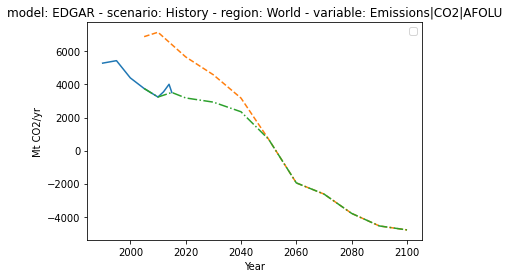

In [29]:
plt.figure()
ax = plt.subplot()
histall_nonghg.filter(variable=co2afolu,region="World").plot(ax=ax)
relevantrcmip.filter(variable=co2afolu,region="World").plot(ax=ax, linestyle="--")
relevantrcmip_harmed.filter(variable=co2afolu,region="World").plot(ax=ax, linestyle="-.")

In [30]:
histall = relevantrcmip_harmed.append(histall)

In [31]:
histall = pyam.IamDataFrame(histall)

In [32]:
histall.filter(region="World", variable="Emissions|PFC|CF4")

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : EDGAR (1)
 * scenario : History (1)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|PFC|CF4 (1)
   unit     : kt CF4/yr (1)
   year     : 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, ... 2019 (50)
Meta indicators:
   exclude (bool) False (1)

In [33]:
kyoto_gases_oddly = [
        'Emissions|C2F6', 
        'Emissions|CF4',
        'Emissions|CH4',
        'Emissions|CO2',
        'Emissions|HFC',
        'Emissions|SF6',
        'Emissions|N2O'
]
fgases = ["Emissions|HFC", 'Emissions|PFC|C2F6', 'EmissionsPFC|CF4', 'Emissions|SF6']
pfcs = ['Emissions|PFC|C2F6', 'Emissions|PFC|CF4']
histco2 = histall.add(
    co2ind,
    co2afolu,
    name=co2,
    ignore_units=True
).data
histco2["unit"] = "Mt CO2/yr"
histco2 = pyam.IamDataFrame(histco2)
histfgas = _construct_consistent_values(
    "Emissions|F-Gases", 
    fgases, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=fgases), metric_name="AR6GWP100")
)
histpfc = _construct_consistent_values(
    "Emissions|PFC", 
    pfcs, 
    convert_units_to_MtCO2_equiv(
        histall.filter(region="World", variable=pfcs), metric_name="AR6GWP100")
)
histall = histall.append(histco2).append(histfgas).append(histpfc)
histkyoto = _construct_consistent_values(
    variable, 
    kyoto_gases_oddly, 
    convert_units_to_MtCO2_equiv(histall.filter(
        region="World", variable=kyoto_gases_oddly), metric_name="AR6GWP100")
)
histall = histall.append(histkyoto)

In [34]:
# Ensure that the fgas totals work for the AR value we are using
fgas = "Emissions|F-Gases"
consistent_fgases = _construct_consistent_values(
    fgas, ["Emissions|SF6", "Emissions|PFC", "Emissions|HFC"], convert_units_to_MtCO2_equiv(
        histall.filter(variable=["Emissions|SF6", "Emissions|PFC*", "Emissions|HFC"]
                      ), metric_name="AR6GWP100"
    )
)
histall = histall.filter(variable=fgas, keep=False).append(consistent_fgases)

In [35]:
histall = histall.filter(year=relevantrcmip_harmed.year)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: EDGAR - scenario: History'}, xlabel='Year', ylabel='Value'>

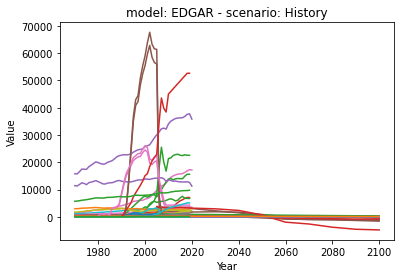

In [36]:
histall.filter(variable=variable).plot()

# Harmonize all values
We harmonise regional non-AFOLU Kyoto totals and global CO2|AFOLU. 

In [37]:
preharm_ts = raw_data.timeseries().reset_index()
preharm_ts.head()

,model,scenario,region,variable,unit,2015,2019,2020,2030
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,55498.5247,56880.931713,57059.242914,58842.354925
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,55498.5247,56880.931713,56912.541426,57228.638549
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,55498.5247,56880.931713,56414.893888,51754.515639
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,55498.5247,56880.931713,56722.972362,55143.378851
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,55498.5247,56880.931713,56452.774389,52171.201141


In [38]:
raw_data = raw_data.interpolate(start_harm_year)

In [39]:
# Harmonise the global projections from all scenarios which we want to reconstruct
harm_year_raw = [y for y in raw_data.year if y < unity_year]
harm_sing = []
for harm_var in [variable]:
    if not histall.filter(region="World", variable=harm_var).empty:
        if harm_var != co2afolu:
            use_offset_method = False
        else:
            use_offset_method = True
        harm_sing.append(
            harmonize(
                raw_data.filter(variable=harm_var, region="World"), 
                harm_var, 
                histall.filter(variable=harm_var, region="World"), 
                start_harm_year,
                offset=use_offset_method
            )
        )
    else: 
        print("Variable {} not harmonised".format(harm_var))
harm_world = pyam.concat(harm_sing)

In [40]:
# We may need to apply the same scaling factors to the regions where the regional
# variables are not available in historic factors. 
harm_vars = [co2afolu, kyexaf]
def harmonise_regions_to_total(harm_regions, harm_world, harm_cols, harm_vars):
    # A function that takes the time series of regional values to harmonise, 
    # the harmonised IamDataFrame for the world (harm_world), the column names
    # in harm_regions to harmonise
    # list of values to harmonise (harm_var)
    harm_sing = []
    harm_world_ts = harm_world.timeseries().reset_index()
    for harm_var in harm_vars:
        print(harm_var)
        max_val_2015 = 1
        min_val_2015 = 1
        for (ind, (model, scenario)) in harm_regions[["model", "scenario"]
                                                    ].drop_duplicates().iterrows():
            ind_to_harm = (harm_regions["scenario"]==scenario) & (harm_regions["model"]==model) & (
                harm_regions["variable"]==harm_var)
            harm_ratio = (harm_world_ts.loc[
                (harm_world_ts["scenario"]==scenario) & (harm_world_ts["model"]==model) & 
                (harm_world_ts["variable"]==harm_var),
                harm_cols
            ].values / harm_regions.loc[
                ind_to_harm & (harm_regions["region"]=="World"),
                harm_cols
            ].values)[0]
            max_val_2015 = max([harm_ratio[1], max_val_2015])
            min_val_2015 = min([harm_ratio[1], min_val_2015])
            harm_regions.loc[ind_to_harm, harm_cols] = harm_regions.loc[
                ind_to_harm, harm_cols] * harm_ratio
            harm_sing.append(pyam.IamDataFrame(harm_regions.loc[ind_to_harm]))
        print(max_val_2015)
        print(min_val_2015)
    return harm_sing

In [41]:
assert np.allclose(
    histall.filter(variable=variable, year=harm_world.year).timeseries()[start_harm_year].iloc[0],
    harm_world.filter(variable=variable, year=harm_world.year).timeseries()[start_harm_year]
)

In [42]:
histall.filter(variable=variable, year=[2015, 2020]).timeseries()

,,,,,2015,2020
model,scenario,region,variable,unit,,
EDGAR,History,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,53646.264185,39008.499108


In [49]:
histall = pyam.IamDataFrame(histall.data)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

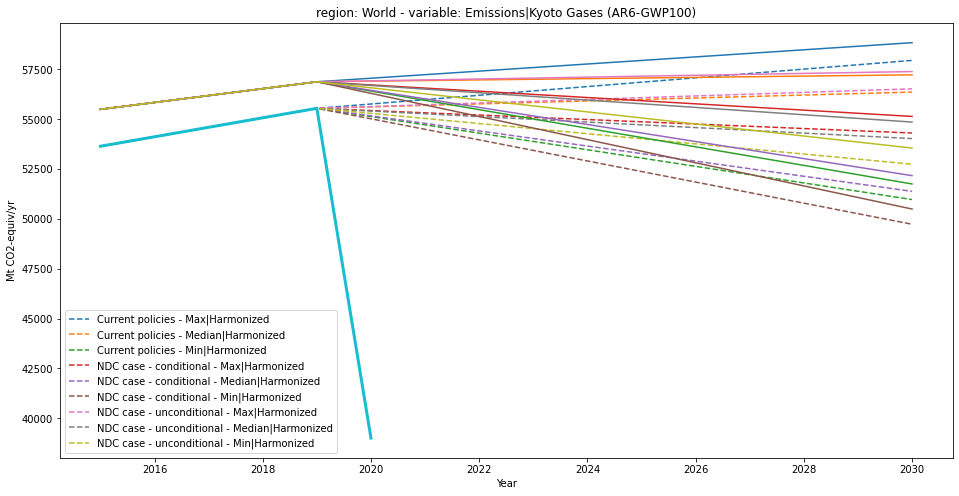

In [50]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

harm_world.filter(variable=variable, region="World").plot(ax=ax, linestyle="--")
histall.filter(variable=variable, year=harm_world.year).plot(ax=ax, linestyle="-", linewidth=3)
raw_data.filter(variable=variable, region="World").plot(ax=ax, linestyle="-")

In [44]:
# Denote harmonisation in scenario names
harm_world = pyam.IamDataFrame(harm_world).data
harm_world["scenario"] = harm_world["scenario"] + "|Harmonized"
harm_world = pyam.IamDataFrame(harm_world)

In [45]:
# Since we don't have regional info in this case
harm_all = harm_world

In [46]:
sr15 = sr15.interpolate(start_harm_year).filter(year=2000, keep=False)

In [47]:
sr15.filter(variable=fgas)

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, GCAM 4.2, IMAGE 3.0.1, ... WITCH-GLOBIOM 4.4 (17)
 * scenario : ADVANCE_2020_1.5C-2100, ADVANCE_2020_Med2C, ... TERL_Baseline_NoTransportPolicy (147)
Timeseries data coordinates:
   region   : R5ASIA, R5LAM, R5MAF, R5OECD90+EU, R5REF, R5ROWO, World (7)
   variable : Emissions|F-Gases (1)
   unit     : Mt CO2-equiv/yr (1)
   year     : 2005, 2010, 2015, 2019, 2020, 2025, 2030, 2035, ... 2100 (21)
Meta indicators:
   exclude (bool) False (1)

In [48]:
histall.filter(variable='Emissions|HFC*')

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : EDGAR (1)
 * scenario : History (1)
Timeseries data coordinates:
   region   : R5ASIA, R5LAM, R5MAF, R5OECD90+EU, R5REF, World (6)
   variable : Emissions|HFC|HFC125, Emissions|HFC|HFC134a, ... Emissions|HFC (15)
   unit     : kt HFC125/yr, kt HFC134a/yr, kt HFC143a/yr, ... Mt CO2-equiv/yr (15)
   year     : 2005, 2010, 2015, 2019 (4)
Meta indicators:
   exclude (bool) False (1)

In [51]:
# Harmonize sr15 too!
harmable_sr15_vars = [
    'Emissions|BC',
    'Emissions|CH4',
    'Emissions|CO',
    'Emissions|CO2',
    'Emissions|CO2|AFOLU',
    'Emissions|CO2|Energy and Industrial Processes',
    'Emissions|F-Gases',
    'Emissions|N2O',
    'Emissions|NH3',
    'Emissions|NOx',
    'Emissions|OC',
    'Emissions|Sulfur',
    'Emissions|VOC',
]
try:
    del harmed_sr15
except:
    pass
for harmvariable in harmable_sr15_vars:
    if harmvariable != co2afolu:
        use_offset_method = False
    else:
        use_offset_method = True
    to_harm = sr15.filter(variable=harmvariable, scenario="SSP*", region="World")
    harmed_sr15_cmpt = harmonize(
        to_harm, harmvariable, histall.filter(region="World"), start_harm_year, offset=use_offset_method)
    try:
        harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
    except: 
        harmed_sr15 = harmed_sr15_cmpt
# Some variables don't exist often enough in the SSP scenarios
fgas_harmvars = [
    'Emissions|SF6',
    'Emissions|HFC',
    'Emissions|PFC',
    'Emissions|PFC|C2F6',
    'Emissions|PFC|CF4'
]
for harmvariable in fgas_harmvars:
    to_harm = sr15.filter(variable=harmvariable, region="World")
    harmed_sr15_cmpt = harmonize(to_harm, harmvariable, histall.filter(region="World"), start_harm_year)
    harmed_sr15 = harmed_sr15.append(harmed_sr15_cmpt)
# And the gases that exist as subcomponents of HFCs are impossible to harmonise and simply appended. 
harmed_sr15 = harmed_sr15.append(sr15.filter(region="World", variable="*|HFC|*"))

unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt HFC134a-equiv/yr'] (current) for variable Emissions|HFC
Converted unit of Emissions|HFC to ['kt HFC134a-equiv/yr']
unit mismatch for  ['Mt CO2-equiv/yr'] (desired) and ['kt CF4-equiv/yr'] (current) for variable Emissions|PFC
Converted unit of Emissions|PFC to ['kt CF4-equiv/yr']


In [52]:
# Introduce the Kyoto gas total with AR6
kyoto_gases = [
    'Emissions|CH4',
    'Emissions|CO2',
    'Emissions|F-Gases',
    'Emissions|N2O'
]
sr15_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15.filter(
        region="World", variable=kyoto_gases, scenario="SSP*"), metric_name="AR6GWP100")
)

In [53]:
assert len(sr15_ky_ar6.timeseries().loc[:, start_harm_year].drop_duplicates().values) == 1

In [54]:
assert np.allclose(
    histkyoto.filter(year=2015).data.value, 
    sr15_ky_ar6.filter(year=2015).data.value.unique(),
    rtol=1e-3
)
assert np.allclose(
    histkyoto.filter(year=start_harm_year).data.value, 
    sr15_ky_ar6.filter(year=start_harm_year).data.value.unique(),
    rtol=1e-3
)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

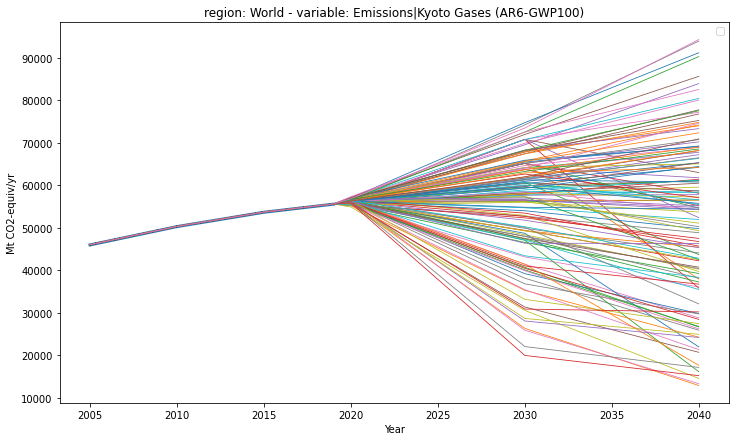

In [55]:
plt.figure(figsize=(12, 7))
ax = plt.subplot()
histkyoto.filter(year=[2005, 2010, 2015, start_harm_year]).plot(ax=ax, linewidth=3)
sr15_ky_ar6.filter(year=[2005, 2010, 2015, start_harm_year, 2020, 2030, 2040]).plot(ax=ax, linewidth=0.8)

In [56]:
harmed_sr15 = harmed_sr15.append(sr15_ky_ar6)

In [57]:
harmed_sr15.timeseries()

2005  \
model             scenario               region variable               unit                              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          kt HFC134a-equiv/yr  563.425511   
                                                Emissions|HFC|HFC125   kt HFC125/yr                NaN   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr               NaN   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr               NaN   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr              NaN   
...                                                                                                ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr           10.812000   
                                                Emissions|HFC|HFC32    kt HFC32/yr           10.993000   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr       1.000000   
                                                Emissions|PFC          kt CF4-equiv/yr       63.996855   
                                                Emissions|SF6          kt SF6/yr              6.644639   

                                                                                                  2010  \
model             scenario               region variable               unit                              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          kt HFC134a-equiv/yr  717.146418   
                                                Emissions|HFC|HFC125   kt HFC125/yr          30.576302   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr        182.725482   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr         25.150486   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr        10.447885   
...                                                                                                ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr            9.522000   
                                                Emissions|HFC|HFC32    kt HFC32/yr           17.942000   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr       1.020500   
                                                Emissions|PFC          kt CF4-equiv/yr       45.323097   
                                                Emissions|SF6          kt SF6/yr              6.497172   

                                                                                                  2015  \
model             scenario               region variable               unit                              
AIM/CGE 2.0       ADVANCE_2020_1.5C-2100 World  Emissions|HFC          kt HFC134a-equiv/yr  900.001679   
                                                Emissions|HFC|HFC125   kt HFC125/yr          75.035229   
                                                Emissions|HFC|HFC134a  kt HFC134a/yr        214.747791   
                                                Emissions|HFC|HFC143a  kt HFC143a/yr         55.801935   
                                                Emissions|HFC|HFC227ea kt HFC227ea/yr         6.870439   
...                                                                                                ...   
WITCH-GLOBIOM 4.2 ADVANCE_Reference      World  Emissions|HFC|HFC23    kt HFC23/yr            2.307122   
                                                Emissions|HFC|HFC32    kt HFC32/yr           15.996166   
                                                Emissions|HFC|HFC43-10 kt HFC4310mee/yr       0.323188   
                                                Emissions|PFC          kt CF4-equiv/yr       46.029436   
                                                Emissions|SF6       

In [58]:
# Unify the regional breakdown of emissions?
"""
def unify_regions_to_totals(df):
    to_return = df.data
    for var in df.variable:
        aggcheck = df.check_aggregate_region(var)
        if aggcheck is not None:
            aggcheck = aggcheck.rename(columns={"region":"whole"}).reset_index()
        else:
            print("no unification possible for {}".format(var))
            continue
        aggcheck["ratio"] = aggcheck.loc[:, "whole"] / aggcheck.loc[:, "subregions"]
        
        for ind, (model, scenario, year) in aggcheck[["model", "scenario", "year"]].iterrows():
            to_return.loc[
                (to_return["region"]!="World") & (to_return["model"]==model) 
                & (to_return["scenario"]==scenario)
                & (to_return["variable"]==var) & (to_return["year"]==year), "value"
            ] *= aggcheck.loc[ind, "ratio"]
        print("Unified {} with ratio {}".format(
            var, aggcheck.loc[ind, "ratio"]))
    return pyam.IamDataFrame(to_return)

histall_unify = unify_regions_to_totals(histall)
"""
histall_unify = histall

In [59]:
harmed_sr15.filter(variable="Emissions|HFC|HFC*").variable

['Emissions|HFC|HFC125',
 'Emissions|HFC|HFC134a',
 'Emissions|HFC|HFC143a',
 'Emissions|HFC|HFC227ea',
 'Emissions|HFC|HFC23',
 'Emissions|HFC|HFC32',
 'Emissions|HFC|HFC43-10',
 'Emissions|HFC|HFC245fa']

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


(2005.0, 2060.0)

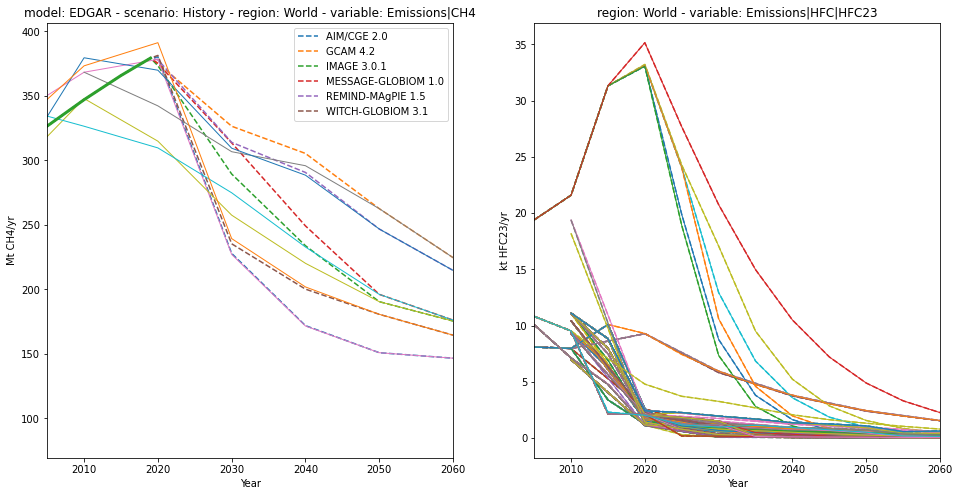

In [60]:
figure = plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
harmed_sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|CH4", scenario="SSP1-2*", region="World").plot(ax=ax, linewidth=1)
histall.filter(variable="Emissions|CH4", region="World").plot(ax=ax, linewidth=3)
plt.xlim([2005, 2060])
ax = plt.subplot(122)
harmed_sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linestyle="--")
sr15.filter(variable="Emissions|HFC|HFC23", region="World").plot(ax=ax, linewidth=1)
plt.xlim([2005, 2060])

Text(2000, 20000, 'expect change if correcting regions')

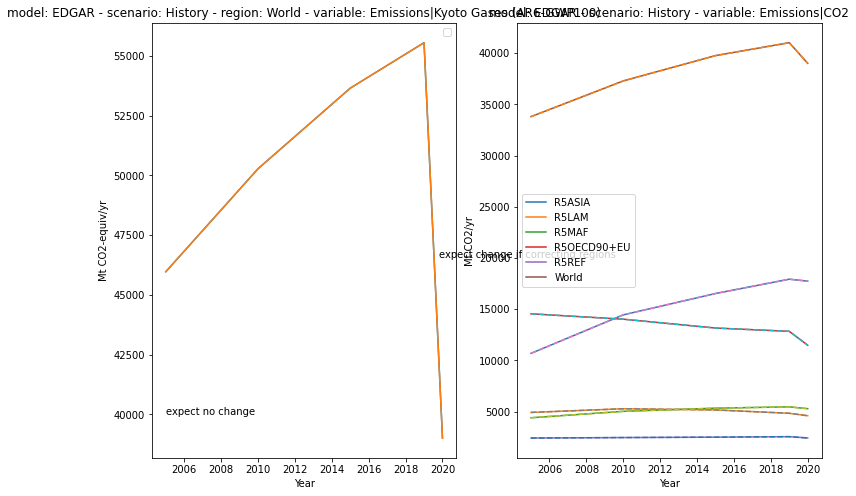

In [61]:
ch4 = "Emissions|CH4"
plt.figure(figsize=(12, 8))
ax = plt.subplot(121)
histall_unify.filter(variable=variable).plot(ax=ax)
histall.filter(variable=variable).plot(ax=ax)
plt.text(x=2005, y=40000, s="expect no change")
ax = plt.subplot(122)
histall_unify.filter(variable=co2).plot(ax=ax)
histall.filter(variable=co2).plot(ax=ax, linestyle="--")
plt.text(x=2000, y=20000, s="expect change if correcting regions")

In [62]:
histall.timeseries().head()

2005        2010  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      3.910000    4.529000   
                      Emissions|C3F8  t C3F8/yr    59.819350   38.078879   
                      Emissions|C4F10 t C4F10/yr    0.058000    0.060410   
                      Emissions|CH4   Mt CH4/yr   126.814128  141.110301   
                      Emissions|CO    Mt CO/yr    354.636749  383.928799   

                                                        2015        2019  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      4.798000    4.167636   
                      Emissions|C3F8  t C3F8/yr    31.588241   19.980628   
                      Emissions|C4F10 t C4F10/yr    0.060410    0.061110   
                      Emissions|CH4   Mt CH4/yr   149.853810  154.794151   
                      Emissions|CO    Mt CO/yr    411.649982  394.625212   

                                                        2020        2030  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      4.016484    3.244132   
                      Emissions|C3F8  t C3F8/yr          NaN         NaN   
                      Emissions|C4F10 t C4F10/yr         NaN         NaN   
                      Emissions|CH4   Mt CH4/yr          NaN         NaN   
                      Emissions|CO    Mt CO/yr    390.417584  366.898227   

                                                        2040        2050  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      2.416685    1.598954   
                      Emissions|C3F8  t C3F8/yr          NaN         NaN   
                      Emissions|C4F10 t C4F10/yr         NaN         NaN   
                      Emissions|CH4   Mt CH4/yr          NaN         NaN   
                      Emissions|CO    Mt CO/yr    322.773485  268.986938   

                                                        2060        2070  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      1.319032    1.124963   
                      Emissions|C3F8  t C3F8/yr          NaN         NaN   
                      Emissions|C4F10 t C4F10/yr         NaN         NaN   
                      Emissions|CH4   Mt CH4/yr          NaN         NaN   
                      Emissions|CO    Mt CO/yr    226.391976  197.660452   

                                                        2080        2090  \
model scenario region variable        unit                                 
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      0.872839    0.634537   
                      Emissions|C3F8  t C3F8/yr          NaN         NaN   
                      Emissions|C4F10 t C4F10/yr         NaN         NaN   
                      Emissions|CH4   Mt CH4/yr          NaN         NaN   
                      Emissions|CO    Mt CO/yr    164.943885  137.633120   

                                                        2100  
model scenario region variable        unit                    
EDGAR History  R5ASIA Emissions|BC    Mt BC/yr      0.476287  
                      Emissions|C3F8  t C3F8/yr          NaN  
                      Emissions|C4F10 t C4F10/yr         NaN  
                      Emissions|CH4   Mt CH4/yr          NaN  
                      Emissions|CO    Mt CO/yr    113.498964

In [63]:
histall.variable

['Emissions|BC',
 'Emissions|C3F8',
 'Emissions|C4F10',
 'Emissions|C5F12',
 'Emissions|C6F14',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|HFC',
 'Emissions|HFC|HFC125',
 'Emissions|HFC|HFC134',
 'Emissions|HFC|HFC134a',
 'Emissions|HFC|HFC143',
 'Emissions|HFC|HFC143a',
 'Emissions|HFC|HFC152a',
 'Emissions|HFC|HFC227ea',
 'Emissions|HFC|HFC23',
 'Emissions|HFC|HFC236fa',
 'Emissions|HFC|HFC245fa',
 'Emissions|HFC|HFC32',
 'Emissions|HFC|HFC365mfc',
 'Emissions|HFC|HFC41',
 'Emissions|HFC|HFC4310mee',
 'Emissions|Kyoto Gases (AR6-GWP100)',
 'Emissions|N2O',
 'Emissions|NF3',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|PFC',
 'Emissions|PFC|C2F6',
 'Emissions|PFC|CF4',
 'Emissions|SF6',
 'Emissions|Sulfur',
 'Emissions|VOC',
 'Emissions|cC4F8']

In [64]:
# harmonise the regional variables in SR1.5 where historic regional variables exist, 
# unify them where they don't
regional_var = [var for var in harmable_sr15_vars 
                if var in histall_unify.filter(region="R5ASIA").variable]
non_region_var = [var for var in harmable_sr15_vars if var not in regional_var]
non_region_var

[]

In [65]:
regional_var

['Emissions|BC',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2',
 'Emissions|CO2|AFOLU',
 'Emissions|CO2|Energy and Industrial Processes',
 'Emissions|F-Gases',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|Sulfur',
 'Emissions|VOC']

In [66]:
orig_ssps = sr15.filter(scenario="SSP*")
regional_ssps = orig_ssps.filter(region="World", keep=False).append(harmed_sr15)

In [67]:
non_region_var

[]

In [68]:
if non_region_var:
    harmed_sr15_regions_to_tot = harmonise_regions_to_total(
        orig_ssps.timeseries().reset_index(), harmed_sr15, years, non_region_var
    )

    harmed_sr15_regions_to_tot = pyam.concat(harmed_sr15_regions_to_tot)
    harmed_sr15_regions_to_tot.check_aggregate_region(co2afolu)
    orig_ssps.check_aggregate_region(co2afolu).head()
else:
    harmed_sr15_regions_to_tot = harmed_sr15

In [69]:
harmed_sr15_regions = harmed_sr15_regions_to_tot
prop_harmed_sr15_regions = []
regions = [r for r in orig_ssps.region if r != "World"]
for var in regional_var:
    for region in regions:
        if var != co2afolu:
            use_offset_method = False
        else:
            use_offset_method = True
        prop_harmed_sr15_regions.append(
            harmonize(
                regional_ssps.filter(variable=var, region=region), 
                var, 
                histall_unify.filter(variable=var, region=region),
                start_harm_year,
                use_offset_method
            )
        )
harmed_sr15_regions = pyam.concat(prop_harmed_sr15_regions).append(
    harmed_sr15_regions).filter(year=2005, keep=False)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


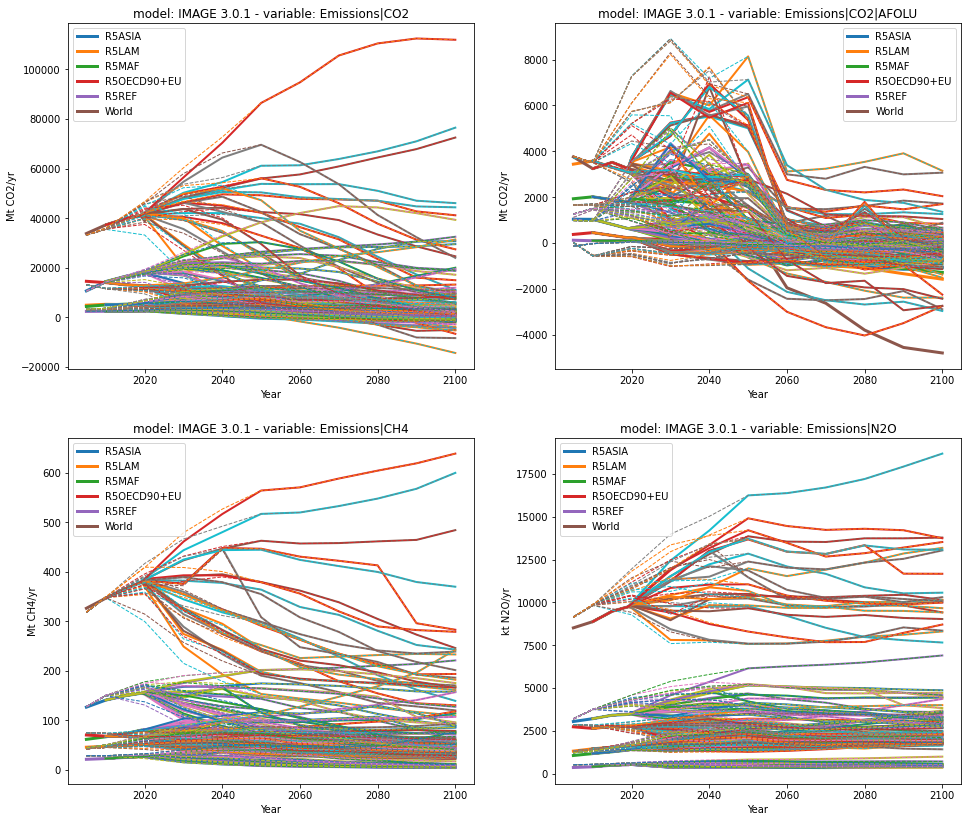

In [70]:
to_plot = [co2, co2afolu, ch4, "Emissions|N2O"]
plt.figure(figsize=(16, 14))
for i in range(4):
    var = to_plot[i]
    ax=plt.subplot(2, 2, i+1)
    pyam.IamDataFrame(histall.filter(variable=var).data).plot(
        ax=ax, linestyle="-", linewidth=3
    )
    harmed_sr15_regions.filter(variable=var, model="IMAGE*").plot(ax=ax, linewidth=2)
    orig_ssps.filter(variable=var, model="IMAGE*").plot(ax=ax, linestyle="--", linewidth=1)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: IMAGE 3.0.1 - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

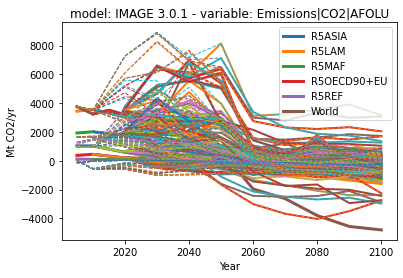

In [71]:
plt.figure()
ax=plt.subplot()
pyam.IamDataFrame(histall.filter(variable=co2afolu).data).plot(
    ax=ax, linestyle="-", linewidth=3
)
harmed_sr15_regions.filter(variable=co2afolu, model="IMAGE*").plot(ax=ax, linewidth=2)
orig_ssps.filter(variable=co2afolu, model="IMAGE*").plot(ax=ax, linestyle="--", linewidth=1)

In [72]:
harmed_sr15_regions.check_aggregate_region(var).head(10)

pyam.core - INFO: `Emissions|N2O` - 519 of 1512 rows are not aggregates of subregions


region  \
model       scenario region variable      unit      year                
AIM/CGE 2.0 SSP1-19  World  Emissions|N2O kt N2O/yr 2020  9804.181454   
                                                    2030  5864.355608   
                                                    2040  5620.450483   
            SSP1-26  World  Emissions|N2O kt N2O/yr 2020  9786.348928   
                                                    2030  6362.836135   
                                                    2040  5968.206345   
            SSP1-34  World  Emissions|N2O kt N2O/yr 2020  9786.348928   
                                                    2030  8003.285886   
                                                    2040  7793.917297   
            SSP1-45  World  Emissions|N2O kt N2O/yr 2020  9757.381789   

                                                           subregions  
model       scenario region variable      unit      year               
AIM/CGE 2.0 SSP1-19  World  Emissions|N2O kt N2O/yr 2020  9792.996291  
                                                    2030  5909.651776  
                                                    2040  5625.389462  
            SSP1-26  World  Emissions|N2O kt N2O/yr 2020  9770.095320  
                                                    2030  6485.761912  
                                                    2040  6006.359267  
            SSP1-34  World  Emissions|N2O kt N2O/yr 2020  9770.095320  
                                                    2030  8100.527121  
                                                    2040  7820.844491  
            SSP1-45  World  Emissions|N2O kt N2O/yr 2020  9729.338285

In [73]:
sr15_region_ky_ar6 = _construct_consistent_values(
    variable, 
    kyoto_gases, 
    convert_units_to_MtCO2_equiv(harmed_sr15_regions.filter(
        variable=kyoto_gases, scenario="SSP*"), metric_name="AR6GWP100")
)

In [74]:
check = sr15_region_ky_ar6.filter(region="R5ASIA").timeseries()[2015].values
assert (max(check) - min (check)) / np.mean(check) < 0.02
check = sr15_region_ky_ar6.filter(region="R5ASIA").timeseries()[start_harm_year].values
assert (max(check) - min (check)) / np.mean(check) < 0.02

In [75]:
harmed_sr15_regions = harmed_sr15_regions.filter(variable=variable, keep=False).append(sr15_region_ky_ar6)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: R5OECD90+EU - variable: Emissions|Kyoto Gases (AR6-GWP100)'}, xlabel='Year', ylabel='Mt CO2-equiv/yr'>

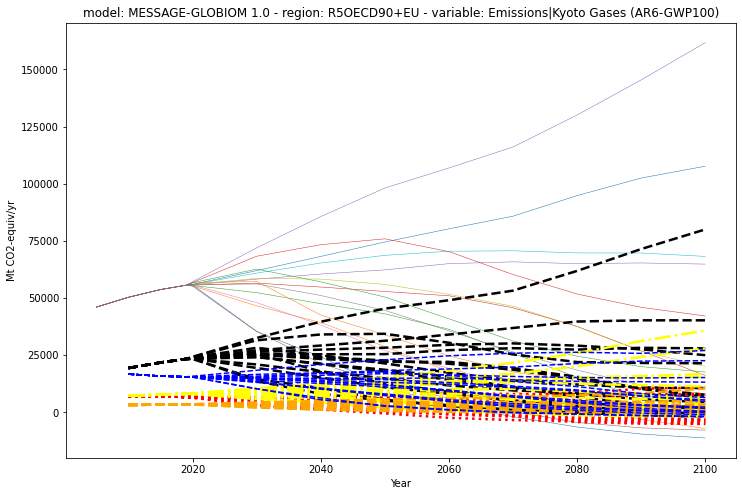

In [76]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15.filter(model=model, variable=variable, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5ASIA").plot(
    ax=ax, linestyle="--", color="black", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5LAM").plot(
    ax=ax, linestyle=":", color="red", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5MAF").plot(
    ax=ax, linestyle="-.", color="yellow", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5REF").plot(
    ax=ax, linestyle="--", color="orange", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=variable, region="R5OECD90+EU").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend
pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'model: MESSAGE-GLOBIOM 1.0 - region: R5OECD90+EU - variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

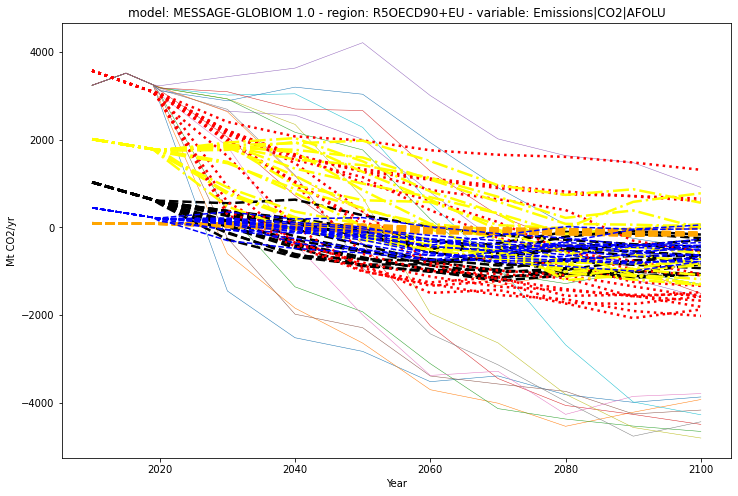

In [78]:
plt.figure(figsize=(12, 8))
model="MESSAGE*"
ax=plt.subplot()
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="World").plot(ax=ax, linewidth=0.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5ASIA").plot(
    ax=ax, linestyle="--", color="black", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5LAM").plot(
    ax=ax, linestyle=":", color="red", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5MAF").plot(
    ax=ax, linestyle="-.", color="yellow", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5REF").plot(
    ax=ax, linestyle="--", color="orange", linewidth=2.5)
harmed_sr15_regions.filter(model=model, variable=co2afolu, region="R5OECD90+EU").plot(
    ax=ax, linestyle="--", color="blue", linewidth=1.5)

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'region: World - variable: Emissions|SF6'}, xlabel='Year', ylabel='kt SF6/yr'>

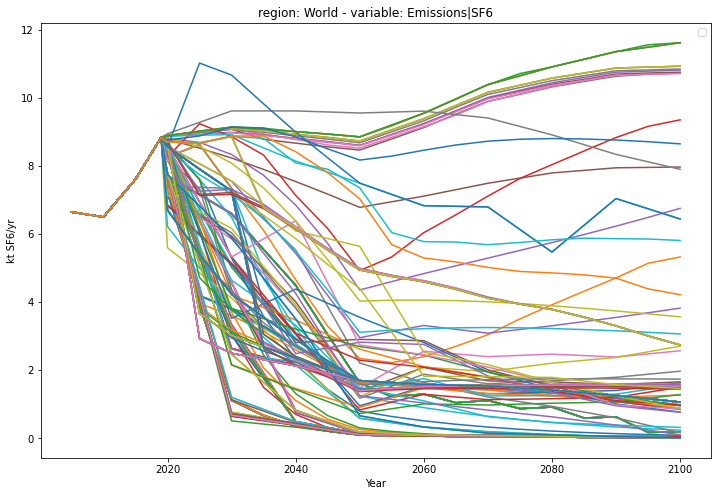

In [79]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
histall.filter(variable="*SF6", region="World").plot(ax=ax, linestyle="--")
harmed_sr15.filter(variable="*SF6", region="World").plot(ax=ax)

In [80]:
harmed_sr15_regions.filter(model=model, variable=co2afolu).check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 91 of 180 rows are not aggregates of subregions


region  \
model               scenario      region variable            unit      year                
MESSAGE-GLOBIOM 1.0 SSP1-19       World  Emissions|CO2|AFOLU Mt CO2/yr 2010  3241.079398   
                                                                       2015  3517.440000   
                                                                       2019  3252.272072   
                                                                       2020  2839.503044   
                                                                       2030 -1448.103663   
...                                                                                  ...   
                    SSP3-Baseline World  Emissions|CO2|AFOLU Mt CO2/yr 2015  3517.440000   
                                                                       2019  3252.272072   
                                                                       2020  3231.432341   
                                                                       2030  3437.583298   
                                                                       2040  3633.278773   

                                                                              subregions  
model               scenario      region variable            unit      year               
MESSAGE-GLOBIOM 1.0 SSP1-19       World  Emissions|CO2|AFOLU Mt CO2/yr 2010  7161.443287  
                                                                       2015  6415.915592  
                                                                       2019  5819.493436  
                                                                       2020  5324.185709  
                                                                       2030   206.931513  
...                                                                                  ...  
                    SSP3-Baseline World  Emissions|CO2|AFOLU Mt CO2/yr 2015  6415.915592  
                                                                       2019  5819.493436  
                                                                       2020  5715.840148  
                                                                       2030  5093.855236  
                                                                       2040  4461.414742  

[91 rows x 2 columns]

In [81]:
sr15.filter(model=model, variable=co2afolu, scenario="SSP*").check_aggregate_region(co2afolu)

pyam.core - INFO: `Emissions|CO2|AFOLU` - 7 of 195 rows are not aggregates of subregions


region  \
model               scenario region variable            unit      year                
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5073.319658   
                                                                  2019  3402.818234   
                                                                  2020  2985.192878   
                                                                  2060 -3515.194641   
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5799.614352   
                                                                  2019  4710.150806   
                                                                  2020  4437.784919   

                                                                         subregions  
model               scenario region variable            unit      year               
MESSAGE-GLOBIOM 1.0 SSP1-19  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5074.384433  
                                                                  2019  3404.735229  
                                                                  2020  2987.322928  
                                                                  2060 -3515.148491  
                    SSP2-26  World  Emissions|CO2|AFOLU Mt CO2/yr 2015  5800.869378  
                                                                  2019  4712.410251  
                                                                  2020  4440.295469

In [82]:
harmed_sr15df = harmed_sr15.filter(variable=co2afolu).timeseries()
harmed_sr15df.loc[(harmed_sr15df==harmed_sr15df.min().min()).any(axis=1), :]

,,,,,2005,2010,2015,2019,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,,,,,,,,,,,,,
GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,3755.732166,3241.079398,3517.44,3252.272072,3052.349249,5311.682649,-9005.093715,-19376.04719,-17111.25453,-12333.22382,-7629.888596,-5074.833732,-3844.293993


pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'variable: Emissions|CO2|AFOLU'}, xlabel='Year', ylabel='Mt CO2/yr'>

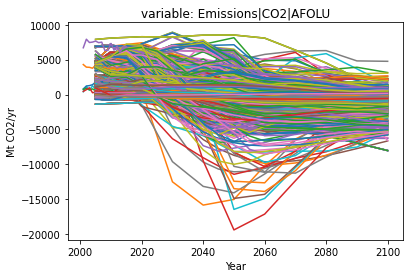

In [83]:
sr15.filter(variable=co2afolu).plot()

pyam.plotting - INFO: >=13 labels, not applying legend


<AxesSubplot:title={'center':'scenario: SSP2-34 - variable: Emissions|CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

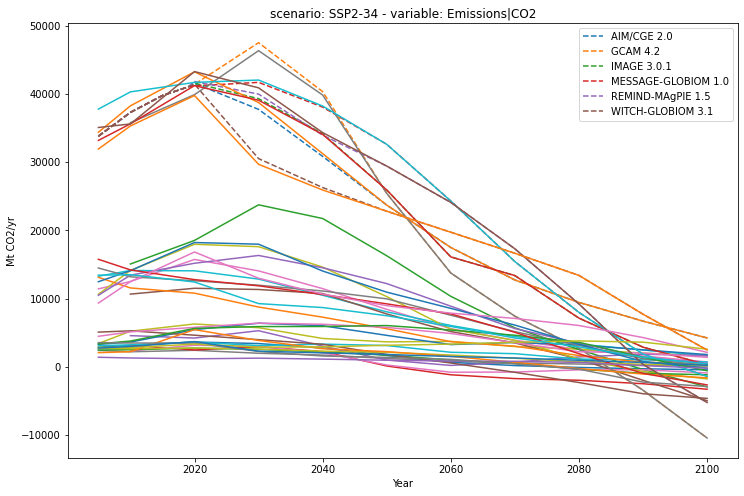

In [84]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
harmed_sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax, linestyle="--")
sr15.filter(variable=co2, scenario=harmed_sr15.scenario[132:133]).plot(ax=ax)

# Plot distribution of 2030 values

In [85]:
harm_all_but_old_names = harm_all.filter(variable=variable, region="World", year=2030).data
harm_all_but_old_names["scenario"] = harm_all_but_old_names["scenario"].str.replace(
    "\|Harmonized", "")
compare_harms_ky = pd.merge(
    raw_data.filter(variable=variable, region="World", year=2030).data,
    harm_all_but_old_names,
    on=("model", "scenario", "region", "year", "variable", "unit"),
    how="outer"
)
compare_harms_ky = compare_harms_ky.rename(columns={"value_x": "Unharmonized", "value_y": "Harmonized"})

C:\Users\rlamboll\Anaconda3\envs\silicone-1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 20.80000000000002, 'Unharmonized 2030 Kyoto total (Mt CO2)')

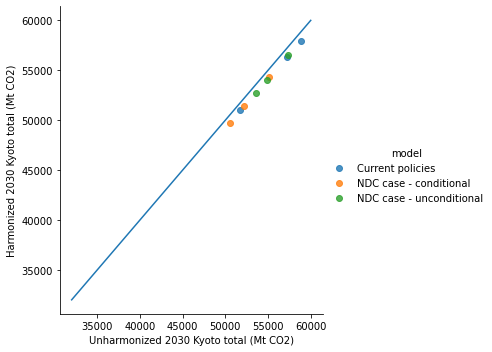

In [86]:
sns.lmplot(x='Unharmonized', y='Harmonized', data=compare_harms_ky, hue='model', fit_reg=False)
plt.plot([32000, 60000], [32000, 60000])
plt.ylabel("Harmonized 2030 Kyoto total (Mt CO2)")
plt.xlabel("Unharmonized 2030 Kyoto total (Mt CO2)")

In [87]:
compare_harms_ky = compare_harms_ky.melt(
    [c for c in compare_harms_ky.columns if c not in ["Unharmonized", "Harmonized"]], var_name="Harmonization"
)
compare_harms_ky.head()

,model,scenario,region,variable,unit,year,Harmonization,value
0,Current policies,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,58842.354925
1,Current policies,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,57228.638549
2,Current policies,Min,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,51754.515639
3,NDC case - conditional,Max,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,55143.378851
4,NDC case - conditional,Median,World,Emissions|Kyoto Gases (AR6-GWP100),Mt CO2-equiv/yr,2030,Unharmonized,52171.201141


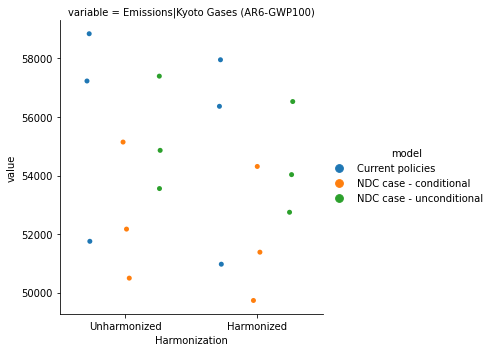

In [88]:
sns.catplot(x="Harmonization", y="value", col="variable", hue="model", 
            data=compare_harms_ky, dodge=True)

# Output harmonised values

In [89]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)
harm_all.to_csv(out_folder + f"harm_all_{version_no}.csv")
harmed_sr15.to_csv(out_folder + "sr15_cleaned_harmed.csv")
harmed_sr15_regions.to_csv(out_folder + "sr15_cleaned_harmed_regions.csv")